## Exploring target activity data from EChEMBL + hERG-central database
## Target activity for the receptor hERG

In [11]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import requests

In [12]:
# install items that need to be installed 

! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

2024-04-18 15:38:47.968338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 15:38:51.770345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 15:38:51.770395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 15:38:51.772238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 15:38:53.365860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 15:38:53.370012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

  Using cached numba-0.59.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numba-0.59.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.8.1 requires numpy<1.25.0,>=1.17.3, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires numba<0.59.0,>=0.56.0, but you have numba 0.59.1 which is incompatible.
ydata-profiling 4.6.4 req

In [13]:
#
# Import AMPL libraries
# 

import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd

# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

In [14]:
# Current working directory 
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)
# List files and directories in the current working directory
files_and_directories = os.listdir(current_directory)
print("Files and directories in the current working directory:", files_and_directories)

Current working directory: /home/jupyter/hERG_Analysis
Files and directories in the current working directory: ['herg_chembl.csv', 'Data Curation.ipynb', 'Compare Models.ipynb', 'Hyperparameter Optimization.ipynb', 'Production Model.ipynb', '.ipynb_checkpoints', 'ApplicationOfModel.ipynb', 'Basic_Model.ipynb']


In [15]:
import pandas as pd

# Reading the downloaded content and turning it into a pandas dataframe
herg_chembl = pd.read_csv('herg_chembl.csv',header=0)
herg_chembl.head(3)

,smiles,class,MW
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,1,440.950
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,1,379.435
2,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,1,324.380


This dataset is drawn from the hERG ChEMBL database and contains the following columns:
    
- `smiles`: The SMILES string that represents the molecule's structure. This is the main
input used to derive features for [AMPL](https://github.com/ATOMScience-org/AMPL) models.
- `class`: Whether compound is an inhibitor (1) or non inhibitor (0)
- `MW`: The molecular weight of the compound, expressed in micromolar (µM) units

In [16]:
# show number of rows in data frame and number of columns
print(herg_chembl.shape)

# show column names
display(herg_chembl.columns)

# get more high level view of data 
herg_chembl.describe()

(7879, 3)


Index(['smiles', 'class', 'MW'], dtype='object')

,class,MW
count,7879.000000,7879.000000
mean,0.476203,438.426625
std,0.499465,86.597457
min,0.000000,94.117000
25%,0.000000,380.517000
50%,0.000000,434.544000
75%,1.000000,492.088500
max,1.000000,1242.488000


## Standardize SMILES
The SMILES grammar allows the same chemical structure to be represented by many different SMILES strings. In addition, measurements may be performed on compounds with different salt groups or with radioisotope labels, which we treat as equivalent to the base compounds. AMPL provides a SMILES standardization function, `base_smiles_to_smiles`, that removes salt groups and isotopes and returns a unique SMILES string for each base compound structure. This step simplifies the machine learning problem by ensuring each compound is represented with the same set of features and multiple measurements on the same compound can be grouped together. 

In [17]:
from atomsci.ddm.utils import struct_utils
from atomsci.ddm.utils.struct_utils import base_smiles_from_smiles

herg_chembl['rdkit_smiles'] = herg_chembl['smiles'].apply(curate_data.base_smiles_from_smiles)
herg_chembl['inchi_key'] = herg_chembl['smiles'].apply(struct_utils.smiles_to_inchi_key)

In [18]:
herg_chembl.smiles.nunique(), herg_chembl.rdkit_smiles.nunique()

(7879, 7879)

In [19]:
herg_chembl.head(3)

,smiles,class,MW,rdkit_smiles,inchi_key
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,1,440.950,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,GZKLJWGUPQBVJQ-UHFFFAOYSA-N
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,1,379.435,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,RMEDXOLNCUSCGS-UHFFFAOYSA-N
2,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,1,324.380,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,UKTAZPQNNNJVKR-KJGYPYNMSA-N


In [22]:
# change column name from inchi_key to compound_id
herg_chembl.rename(columns={ "inchi_key" : "compound_id"}, inplace=True)
herg_chembl = herg_chembl.drop('smiles',axis=1)
herg_chembl.head()

,class,MW,rdkit_smiles,compound_id
0,1,440.950,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,GZKLJWGUPQBVJQ-UHFFFAOYSA-N
1,1,379.435,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,RMEDXOLNCUSCGS-UHFFFAOYSA-N
2,1,324.380,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,UKTAZPQNNNJVKR-KJGYPYNMSA-N
3,1,454.611,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,SGTNSNPWRIOYBX-UHFFFAOYSA-N
4,1,500.432,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,FOHHNHSLJDZUGQ-UHFFFAOYSA-N


For this dataset there are 7879 unique SMILES that are standardized to 7879 unique base SMILES. This has shown us that no two different SMILES strings have been standardized to the same value. From now on we will use rdkit_smiles to represent compound structures. This also points to the fact that there are no duplicate compounds. 

In addition, using the AMPL function `smiles_to_inchi_key` we have derived the inchi_key (or compound_id) given each smile. This will help in further analysis. 

In [ ]:
# convert this dataset with smiles into a csv file 
#herg_chembl.to_csv('herg_chembl_smiles.csv',index=False)

# Visualize the Data

Post-processing dataset

Total Number of results = 7879
dataset mean = 438.4266253764304 number
dataset stdev = 86.59745664133855 number
dataset max = 1242.4879999999991 number
dataset min = 94.117 number



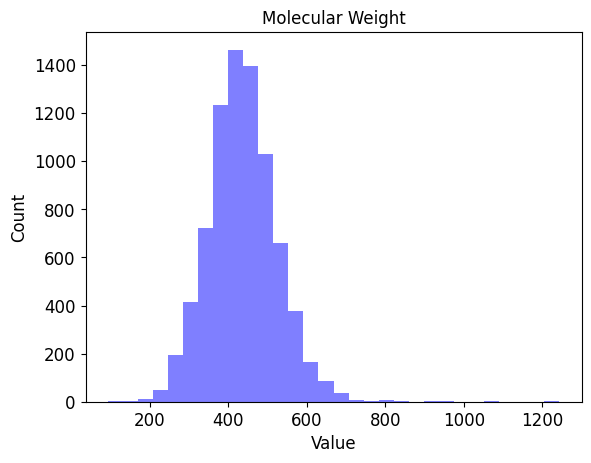

In [23]:
# Our outcome is MW
column = 'MW'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 30

# Ue the target_name as the title for the plot 
title = 'Molecular Weight'

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'number'

# filepath, in this case, current dir
filepath = ""

# dataset with smiles 
data=herg_chembl

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of Molecular Weight)
#   dataset stdev: (sd of Molecular Weight)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [24]:
# column: Response values column
column = 'MW'

# tolerance: Percentage of individual respsonse values allowed to differ from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response 
# value. 
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case
 

curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                       max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (7879, 8)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, MW, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (7879, 8)
New column created with averaged values:  VALUE_NUM_mean


In [25]:
curated_file = os.path.join('herg_curated.csv')
# convert pandas dataframe into csv file
curated_df.to_csv(curated_file, index=False)

Post-processing dataset

Total Number of results = 7879
dataset mean = 0.47620256377712905 number
dataset stdev = 0.49946505792280943 number
dataset max = 1 number
dataset min = 0 number



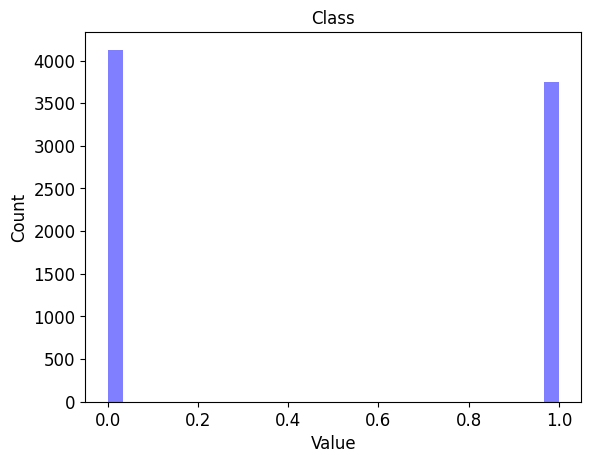

In [27]:
# Convert 'class' to categorical - tried this but had to convert back to int for visualization purposes
herg_chembl['class'] = herg_chembl['class'].astype(int)

# Our outcome is MW
column = 'class'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 30

# Ue the target_name as the title for the plot 
title = 'Class'

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'number'

# filepath, in this case, current dir
filepath = ""

# save_smiles_df was defined earlier
data=herg_chembl

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of Molecular Weight)
#   dataset stdev: (sd of Molecular Weight)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

Failed to patch pandas - unable to change molecule rendering


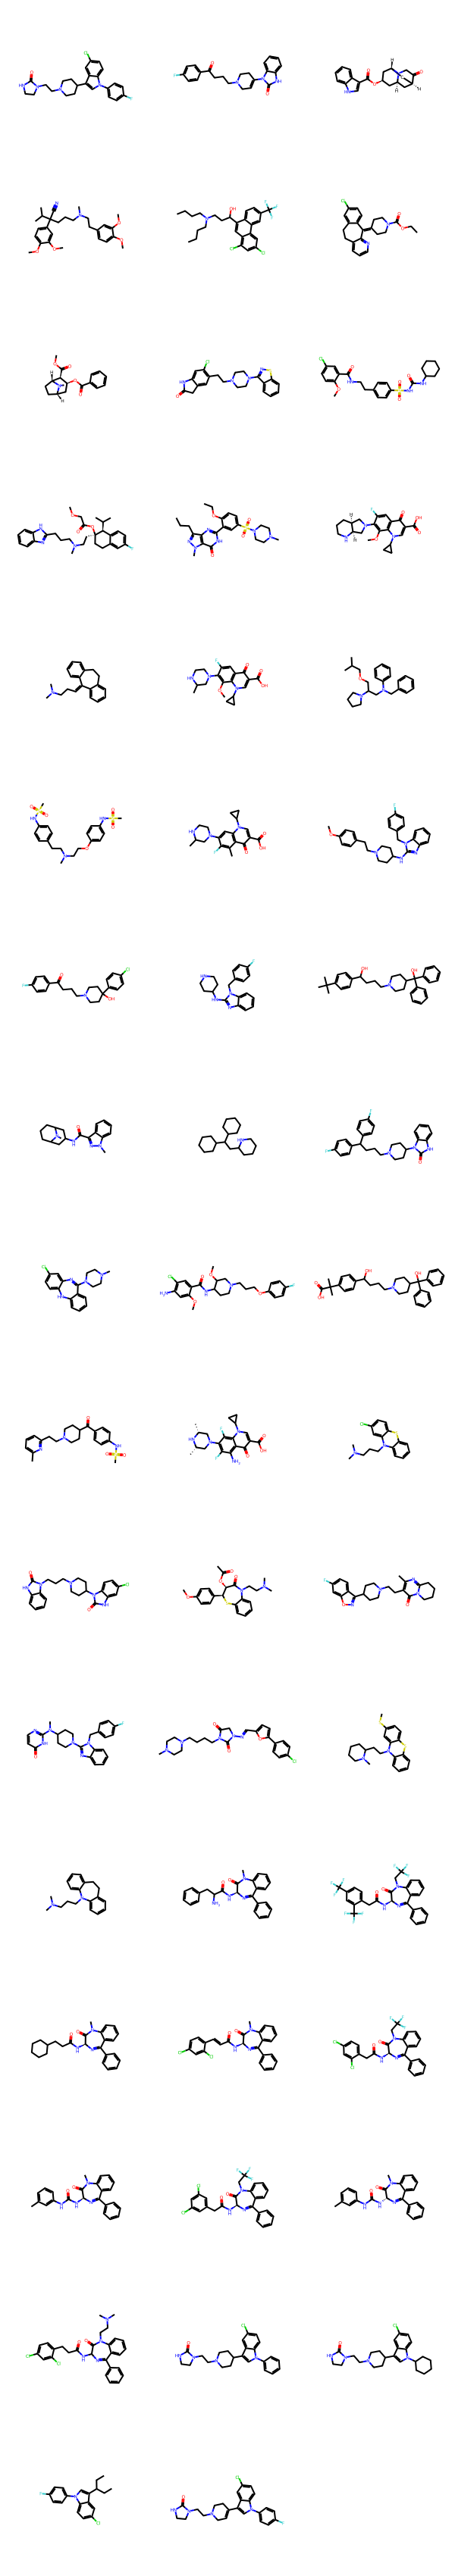

In [29]:
# Visual representation of the chemical structures corresponding to the SMILES strings 

from IPython.display import display
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw

PandasTools.AddMoleculeColumnToFrame(herg_chembl, 'rdkit_smiles', 'Molecule')

# Chemical Structure Visualization
img = Draw.MolsToGridImage(list(herg_chembl['Molecule']), molsPerRow=3)
display(img)

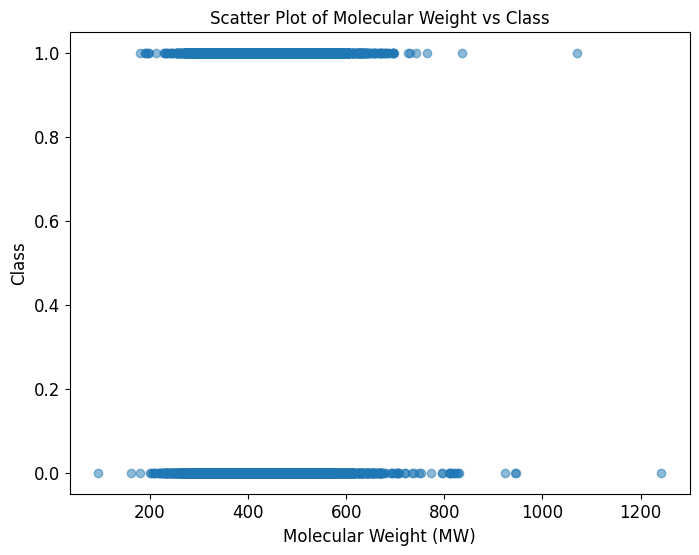

In [30]:
import matplotlib.pyplot as plt

# Scatter Plot of 'MW' vs 'class'
plt.figure(figsize=(8, 6))
plt.scatter(herg_chembl['MW'], herg_chembl['class'], alpha=0.5)
plt.xlabel('Molecular Weight (MW)')
plt.ylabel('Class')
plt.title('Scatter Plot of Molecular Weight vs Class')
plt.show()

<Figure size 600x400 with 0 Axes>

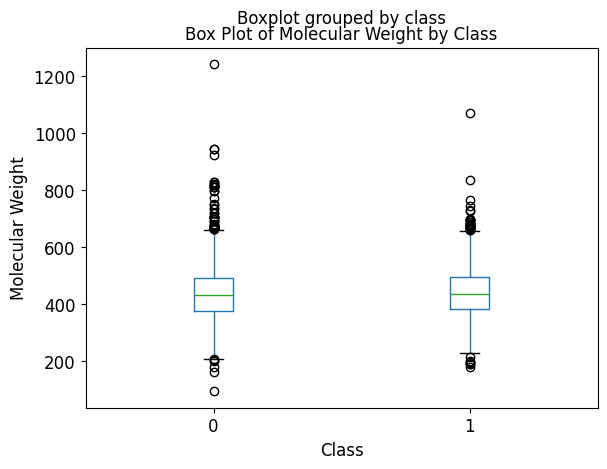

In [31]:
# Box Plot of Molecular Weight by Class
plt.figure(figsize=(6, 4))
herg_chembl.boxplot(column='MW', by='class', grid=False)
plt.xlabel('Class')
plt.ylabel('Molecular Weight')
plt.title('Box Plot of Molecular Weight by Class')
plt.show()

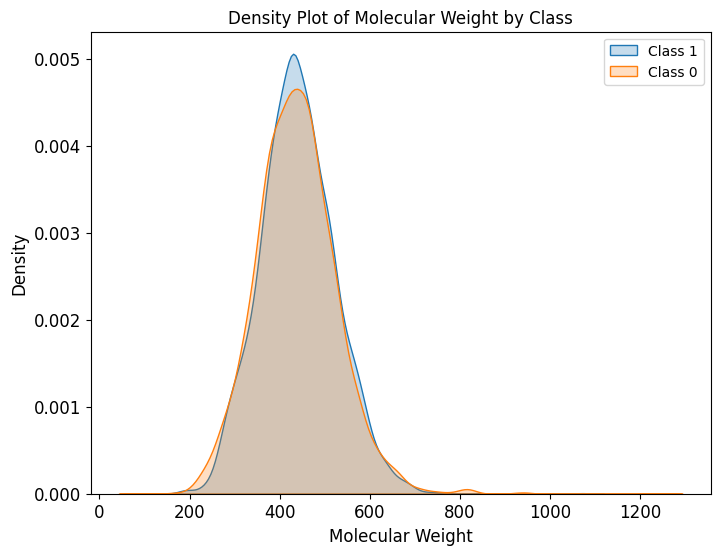

In [32]:
import seaborn as sns

# Density Plot of Molecular Weight by Class
plt.figure(figsize=(8, 6))
for i in herg_chembl['class'].unique():
    subset = herg_chembl[herg_chembl['class'] == i]
    sns.kdeplot(subset['MW'], label=f'Class {i}', shade=True)
plt.xlabel('Molecular Weight')
plt.ylabel('Density')
plt.title('Density Plot of Molecular Weight by Class')
plt.legend()
plt.show()

In [33]:
import pandas as pd

# Set for less chatty log messages
import logging
logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)

In [34]:
herg_chembl.head()

,class,MW,rdkit_smiles,compound_id,Molecule
0,1,440.950,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,GZKLJWGUPQBVJQ-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fa354fce660>
1,1,379.435,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,RMEDXOLNCUSCGS-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fa354fce190>
2,1,324.380,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,UKTAZPQNNNJVKR-KJGYPYNMSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fa354fce9e0>
3,1,454.611,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,SGTNSNPWRIOYBX-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fa354fce430>
4,1,500.432,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,FOHHNHSLJDZUGQ-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fa354fce970>


In [35]:
# drop Molecule column that was added for visualization purposes
final_herg_chembl= herg_chembl.drop(herg_chembl.columns[-1:], axis=1)

In [36]:
final_herg_chembl.head(3)

,class,MW,rdkit_smiles,compound_id
0,1,440.950,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,GZKLJWGUPQBVJQ-UHFFFAOYSA-N
1,1,379.435,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,RMEDXOLNCUSCGS-UHFFFAOYSA-N
2,1,324.380,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,UKTAZPQNNNJVKR-KJGYPYNMSA-N


In [37]:
# Save new curated dataframe into CSV file to be used in the future

final_herg_chembl.to_csv('herg_chembl_curated.csv', index=False)

# Splitting Datasets for Validation, Testing, and Training

## Scaffold Split

In [44]:
# Set up file location and file name 
dataset_file = '/home/jupyter/hERG_Analysis/herg_chembl_curated.csv'
odir = '/home/jupyter/hERG_Analysis'

In [45]:
# start with a dictionary of parameters for scaffold split

params = {
    "verbose": "True",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : "class",
    "id_col": "compound_id",
    "smiles_col" : "rdkit_smiles",
    "result_dir": odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    # specify that splitter is scaffold
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "previously_featurized": "True",
}

In [46]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
scaffold_split_uuid = MP.split_dataset()

2024-04-18 15:50:38,271 Featurized dataset not previously saved for dataset herg_chembl_curated, creating new
2024-04-18 16:11:18,241 Splitting data by scaffold
2024-04-18 16:11:22,706 Dataset split table saved to /home/jupyter/hERG_Analysis/herg_chembl_curated_train_valid_test_scaffold_5f834022-46ac-4c7b-bca1-9573f6eb940f.csv


The dataset split table is saved as a .csv in the same directory as the `dataset_key`. 
The name of the split file starts with the `dataset_key` and is followed by the split 
strategy (train_valid_test), split type (scaffold), and the split_uuid (a unique identifier of the split).

In [47]:
# display the split file location
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{scaffold_split_uuid}*")[0]
split_file

'/home/jupyter/hERG_Analysis/herg_chembl_curated_train_valid_test_scaffold_5f834022-46ac-4c7b-bca1-9573f6eb940f.csv'

In [48]:
# Explore contents of the split file
split_df = pd.read_csv(split_file)
split_df

# Show the numbers of compounds in each split subset
split_df.subset.value_counts()

subset
train    5515
valid    1182
test     1182
Name: count, dtype: int64

## Visualizing Scaffold Splits
[Tanimoto distance](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance) is a handy way 
to measure structural dissimilarity between compounds represented using [ECFP fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t). 

We can use functions in the `compare_splits_plots` module to compute Tanimoto distances between each validation and
test set compound and its nearest neighbor in the training set, and then plot the distribution of distances for 
each subset. 

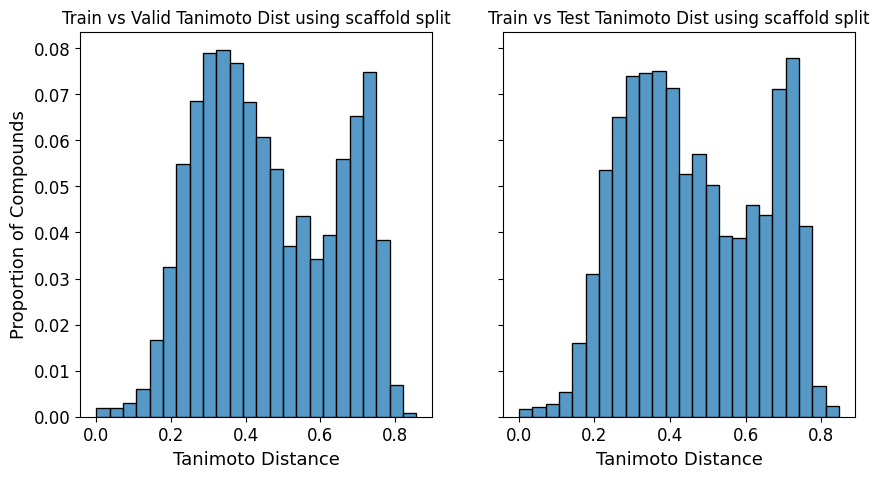

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

# read the dataset
df = pd.read_csv('/home/jupyter/hERG/final_herg_chembl.csv')

# read the split file
split = pd.read_csv(split_file)
split_type = params['splitter']

# create SplitStats
ss = csp.SplitStats(df, split, smiles_col='rdkit_smiles', id_col='compound_id', response_cols=['class']) 

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tanimoto Dist using {split_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tanimoto Dist using {split_type} split");

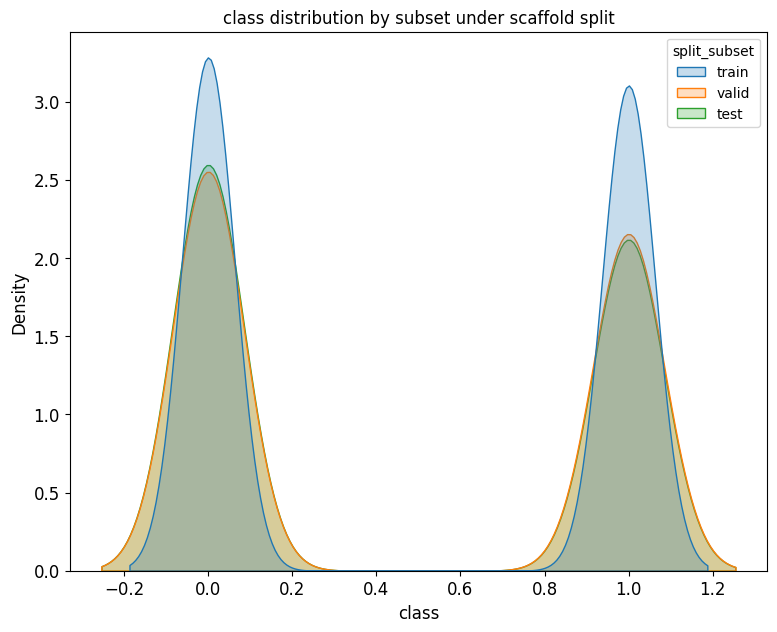

In [50]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : "rdkit_smiles",
    "response_cols" : "class",
    "split_uuid": scaffold_split_uuid,
    "splitter": 'scaffold',
}
srdp.plot_split_subset_response_distrs(split_params)

## Random Split

In [51]:
# start with a dictionary of parameters for random split

params = {
    "verbose": "True",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : "class",
    "id_col": "compound_id",
    "smiles_col" : "rdkit_smiles",
    "result_dir": odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    # specify that splitter is random
    "splitter": 'random',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "previously_featurized": "True",
}

In [52]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
random_split_uuid = MP.split_dataset()

2024-04-18 16:21:31,363 Using prefeaturized data; number of features = 200
2024-04-18 16:21:31,365 Splitting data by random
2024-04-18 16:21:31,456 Dataset split table saved to /home/jupyter/hERG_Analysis/herg_chembl_curated_train_valid_test_random_ac01fe91-0793-4566-9340-2ff90e6a58c5.csv


In [53]:
# display the split file location
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{random_split_uuid}*")[0]
split_file

'/home/jupyter/hERG_Analysis/herg_chembl_curated_train_valid_test_random_ac01fe91-0793-4566-9340-2ff90e6a58c5.csv'

In [54]:
# Explore contents of the split file
split_df = pd.read_csv(split_file)
split_df

# Show the numbers of compounds in each split subset
split_df.subset.value_counts()

subset
train    5515
valid    1182
test     1182
Name: count, dtype: int64

## Visualizing Random Split

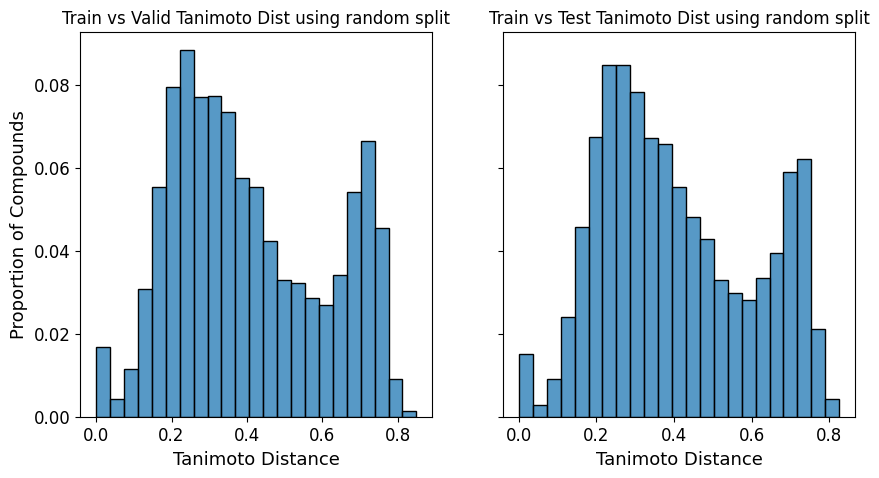

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

# read the dataset
df = pd.read_csv('/home/jupyter/hERG/final_herg_chembl.csv')

# read the split file
split = pd.read_csv(split_file)
split_type = params['splitter']

# create SplitStats
ss = csp.SplitStats(df, split, smiles_col='rdkit_smiles', id_col='compound_id', response_cols=['class']) 

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tanimoto Dist using {split_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tanimoto Dist using {split_type} split");

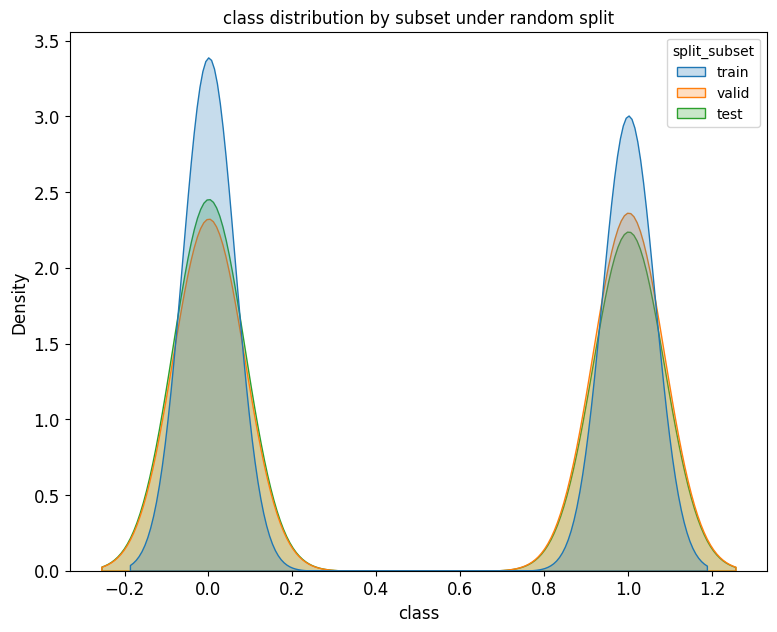

In [56]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : "rdkit_smiles",
    "response_cols" : "class",
    "split_uuid": random_split_uuid,
    "splitter": 'random',
}
srdp.plot_split_subset_response_distrs(split_params)

## Fingerprint Split

In [57]:
# start with a dictionary of parameters for fingerprint split

params = {
    "verbose": "True",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : "class",
    "id_col": "compound_id",
    "smiles_col" : "rdkit_smiles",
    "result_dir": odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    # specify that splitter is fingerprint
    "splitter": 'fingerprint',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "previously_featurized": "True",
}

In [58]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
fingerprint_split_uuid = MP.split_dataset()

2024-04-18 16:22:41,435 Using prefeaturized data; number of features = 200
2024-04-18 16:22:41,437 Splitting data by fingerprint
2024-04-18 16:22:50,444 Dataset split table saved to /home/jupyter/hERG_Analysis/herg_chembl_curated_train_valid_test_fingerprint_64ffab14-47a7-44e8-bfa1-8576f640e241.csv


In [59]:
# display the split file location
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{fingerprint_split_uuid}*")[0]
split_file

'/home/jupyter/hERG_Analysis/herg_chembl_curated_train_valid_test_fingerprint_64ffab14-47a7-44e8-bfa1-8576f640e241.csv'

In [60]:
# Explore contents of the split file
split_df = pd.read_csv(split_file)
split_df

# Show the numbers of compounds in each split subset
split_df.subset.value_counts()

subset
train    5515
test     1183
valid    1181
Name: count, dtype: int64

## Visualizing Fingerprint Split

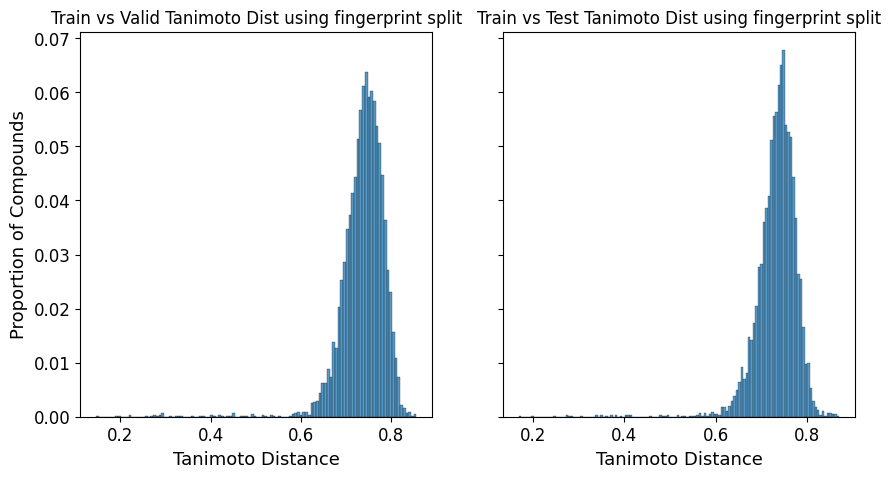

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

# read the dataset
df = pd.read_csv('/home/jupyter/hERG/final_herg_chembl.csv')

# read the split file
split = pd.read_csv(split_file)
split_type = params['splitter']

# create SplitStats
ss = csp.SplitStats(df, split, smiles_col='rdkit_smiles', id_col='compound_id', response_cols=['class']) 

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tanimoto Dist using {split_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tanimoto Dist using {split_type} split");

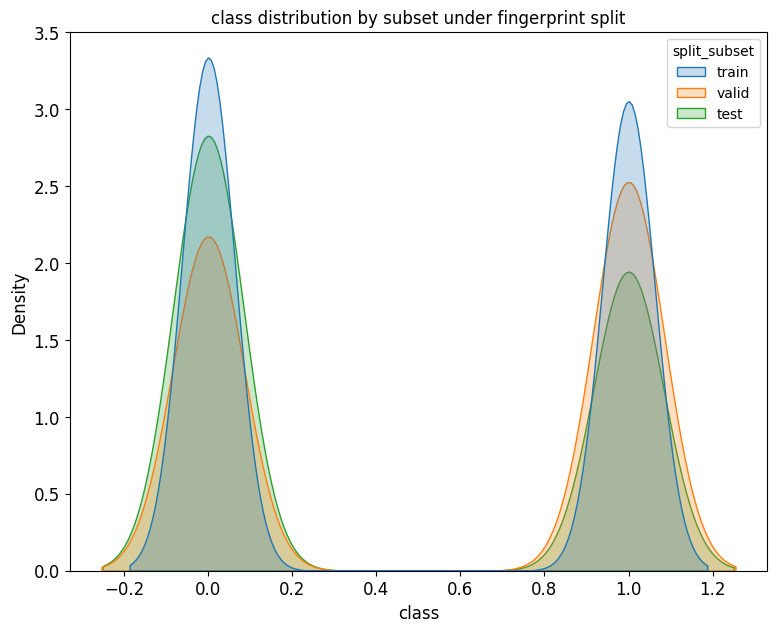

In [62]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : "rdkit_smiles",
    "response_cols" : "class",
    "split_uuid": fingerprint_split_uuid,
    "splitter": 'fingerprint',
}
srdp.plot_split_subset_response_distrs(split_params)